In [1]:
import os
import sys
from pathlib import Path
path = str(Path(os.getcwd()))
sys.path.insert(1, path+'/amazon-braket-community-detection/src')

In [2]:
# Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from geopy.distance import geodesic
import networkx as nx

df = pd.read_csv(path+'/database/SolarPowerPlants_TH.csv', delimiter=',', skiprows=1)
df

,WKT,Index,latitude,longitude,name,capacity(MW),year PV energy production,Price(0.057/kWh)(USD),Num. Solar panel,Total price
0,POINT (100.1995973 13.5797688),1,13.579769,100.199597,Samut Sakhon,5.0,1408.14,80.26398,10000,802639.800
1,POINT (100.4800113 13.7131258),2,13.713126,100.480011,The Mall - Tha Phra,1.0,1408.99,80.31243,2000,160624.860
2,POINT (100.4474445 13.8199492),3,13.819949,100.447445,Ratchaphruek,1.0,1390.08,79.23456,2000,158469.120
3,POINT (100.5417601 13.8550947),4,13.855095,100.541760,The Mall - Ngamwongwan,1.0,1385.64,78.98148,2000,157962.960
4,POINT (100.6421705 13.7658514),5,13.765851,100.642171,The Mall - Bangkapi,1.0,1385.64,78.98148,2000,157962.960
5,POINT (100.6798205 13.8282182),6,13.828218,100.679821,Akekamai-Ramintra,1.0,1385.15,78.95355,2000,157907.100
6,POINT (101.0033703 13.5759609),7,13.575961,101.003370,Chachoengsao,1.3,1353.26,77.13582,2600,200553.132
7,POINT (100.5528226 14.1690859),8,14.169086,100.552823,Bangchak,16.0,1371.40,78.16980,32000,2501433.600
8,POINT (100.5530586 14.1689819),9,14.168982,100.553059,Bangchak III,25.0,1371.40,78.16980,50000,3908490.000
9,POINT (100.1837652 13.9754302),10,13.975430,100.183765,Sai Thong,6.1,1378.22,78.55854,12200,958414.188


In [3]:
ind = df['Index']
name = df['name']
lat = df['latitude']
long = df['longitude']
capacity = df['capacity(MW)']
penetration = df['Total price']


In [4]:
locations = {ind: (lat, long) for ind, lat, long in zip(ind, lat, long)}
locations

{1: (13.5797688, 100.1995973),
 2: (13.7131258, 100.4800113),
 3: (13.8199492, 100.4474445),
 4: (13.8550947, 100.5417601),
 5: (13.7658514, 100.6421705),
 6: (13.8282182, 100.6798205),
 7: (13.5759609, 101.0033703),
 8: (14.1690859, 100.5528226),
 9: (14.1689819, 100.5530586),
 10: (13.9754302, 100.1837652),
 11: (13.9840662, 100.1962857),
 12: (14.0004893, 100.200201),
 13: (14.1076288, 100.1737777),
 14: (14.1367617, 100.1432434),
 15: (14.1383847, 100.1506249),
 16: (14.1542604, 100.1377288),
 17: (14.2224476, 100.1128729),
 18: (14.2446193, 100.1275879),
 19: (14.3219005, 100.3022163),
 20: (14.2172742, 100.2778664)}

In [5]:
(len(locations.keys()))

20

In [6]:

# noconsumers = 10
# c_energy = np.random.default_rng().normal(loc=np.average(capacity), scale=np.std(capacity)/2, size=noconsumers)
# # c_energy = np.random.default_rng().integers(low=min(capacity), high=max(capacity), size=10)
# c_energy

In [7]:
def calculate_distance_mgpp(mglat, mglong, pplat, pplong):    
    distance_matrix = np.zeros(len(pplat))
    for i in range(len(pplat)):
        distance_matrix[i] = geodesic((mglat, mglong), (pplat[i], pplong[i])).km
    return distance_matrix


In [8]:
def calculate_distance_mgmg(mglat, mglong):    
    distance_matrix = np.zeros((len(mglat), len(mglat)))
    for i in range(len(mglat)):
        for j in range(len(mglat)):
            if i < j:
                distance_matrix[i][j] = geodesic((mglat[i], mglong[i]), (mglat[j], mglong[j])).km
    return distance_matrix

In [9]:
# def create_transmission_network(locations, distance_matrix, threshold=45):
#     G = nx.Graph()
#     for i, label_i in enumerate(locations.keys()):
#         for j, label_j in enumerate(locations.keys()):
#             if i < j:
#                 if distance_matrix[i][j] < threshold: # Only add edge if distance is below threshold
#                     G.add_edge(label_i, label_j)
#     return G

In [10]:
print(enumerate(locations.keys()))

In [11]:
# distance_matrix = calculate_distance_matrix(lat, long)

# # Create Graph Based on Distance Threshold
# G = create_transmission_network(locations, distance_matrix, threshold=45)

# # Visualize Graph
# fig, ax = plt.subplots()
# pos = {label: (lon, lat) for label, (lat, lon) in locations.items()}
# nx.draw(G, pos, ax=ax, node_size=100, node_color='blue')
# # nx.draw(G, pos, ax=ax, node_size=800, with_labels=True)
# # with_labels=True, node_color='lightblue', node_size=800)
# plt.title("Solar Panel Proximity Graph")
# plt.show()

In [12]:
# total_nodes = len(G.nodes(data=True))
# total_edges = len(G.edges(data=True))

In [13]:
import scipy.sparse as sp
from networkx.algorithms import community

### create QUBO matrix
# define the distance matrix
num_powerplants = (len(locations.keys())) ## number of solar power plants
pplat, pplong = zip(*locations.values())

In [14]:
# generate choices for microgrid locations
num_microgrids = 5 ## number of microgrids
random_lat = np.random.uniform(min(lat), max(lat), size=4*num_microgrids)
lat_choices = np.random.choice(random_lat, size=num_microgrids, replace=False)

random_long = np.random.uniform(min(long), max(long), size=4*num_microgrids)
long_choices = np.random.choice(random_long, size=num_microgrids, replace=False)

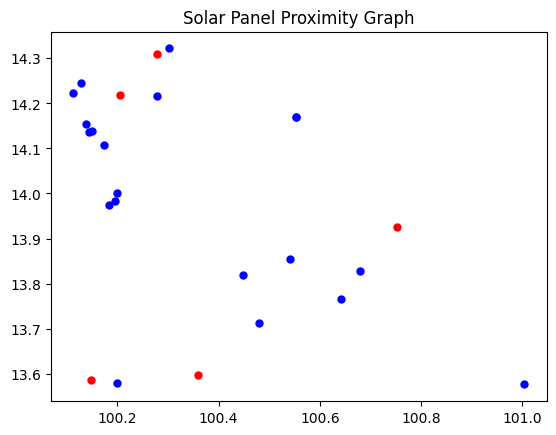

In [15]:
# Visualize Graph
fig, ax = plt.subplots()
ax.plot(long, lat, 'o', markersize=5, color='blue')
ax.plot(long_choices, lat_choices, 'o', markersize=5, color='red')
plt.title("Solar Panel Proximity Graph")
plt.show()

In [16]:
mgpp_distance = np.zeros(num_microgrids)
for i in range(num_microgrids):
    mgpp_distance[i] = np.sum(calculate_distance_mgpp(lat_choices[i], long_choices[i],pplat, pplong))
mgpp_distance

array([1074.6175798 ,  727.87172966, 1056.10860572,  843.27557412,
       1181.03630567])

In [17]:
mgmg_distance = calculate_distance_mgmg(lat_choices, long_choices)
mgmg_distance

array([[ 0.        , 70.92175657, 56.08111432, 79.42902597, 22.9019099 ],
       [ 0.        ,  0.        , 67.44887958, 12.71137345, 70.32838683],
       [ 0.        ,  0.        ,  0.        , 66.55634296, 75.47406053],
       [ 0.        ,  0.        ,  0.        ,  0.        , 81.27990001],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [18]:
costCoeff = 10000
mgpp_cost = mgpp_distance * costCoeff
mgmg_cost = mgmg_distance * costCoeff

battery_cost = 38000  # Example fixed cost for battery and inverter installation
solar_cost = 15000  # Example fixed cost for solar panel installation
fixedCost = battery_cost + solar_cost

In [19]:
np.array(penetration)

array([ 802639.8  ,  160624.86 ,  158469.12 ,  157962.96 ,  157962.96 ,
        157907.1  ,  200553.132, 2501433.6  , 3908490.   ,  958414.188,
        471395.7  , 1131538.464, 5639930.208, 3738735.336, 1523781.342,
       1869693.252, 1100657.46 ,  157290.36 ,  267252.138,  471980.52 ])

In [20]:
np.array(penetration[0:5])

array([802639.8 , 160624.86, 158469.12, 157962.96, 157962.96])

In [21]:
### QUBO matrix
term1 = (fixedCost*np.ones((1, num_microgrids))) + np.array(penetration[0:5]) - mgpp_cost
linearTerm = np.zeros((num_microgrids, num_microgrids))
for i in range(num_microgrids):
    linearTerm[i,i] = term1[0,i]
quandTerm = mgmg_cost
qubo_matrix = linearTerm + quandTerm

In [ ]:
qubo_matrix

In [151]:
from autoqubo import SamplingCompiler, Utils
import timeit

In [152]:
start = timeit.default_timer()

solutions, energy_values = Utils.solve(qubo_matrix)

stop = timeit.default_timer()
print('Time: ', stop - start)

ModuleNotFoundError: No module named 'dwave_qbsolv'

In [ ]:
for s, e in zip(solutions, energy_values):
    print(f"x={s}, energy={e}")

In [ ]:
sum(solutions[0])

In [153]:
from gurobi_optimods.qubo import solve_qubo


start = timeit.default_timer()
 
result = solve_qubo(qubo_matrix)

stop = timeit.default_timer()
print('Time: ', stop - start)

New QUBO solution found with objective 0.0
New QUBO solution found with objective -41095110.74850967
Time:  0.11130245798267424


In [154]:
result

QuboResult(solution=array([1., 1., 1., 1., 1.]), objective_value=-41095110.74850967)

In [51]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
 
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler


In [23]:
from qiskit import QuantumCircuit
qiskit_circuit = QuantumCircuit(num_microgrids + 1)


In [24]:
sum([qubo_matrix[0][m] for m in range(num_microgrids)])

-7597197.930445612

In [25]:
def build_qubo_paulis(qubo) -> list[tuple[str, float]]:
    pauli_list = []
    for i in range(num_microgrids):
        for j in range(num_microgrids):
            if i == j:
                pauli_list.append(("Z", [i], (-1)*sum([qubo[i][j]+qubo[i][i] for j in range(num_microgrids)])))
            else:
                pauli_list.append(("ZZ", [i, j], qubo[i][j]))
    return pauli_list
    # for edge in list(graph.edge_list()):
    #     weight = graph.get_edge_data(edge[0], edge[1])
    #     pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    # return pauli_list
 
qubo_paulis = build_qubo_paulis(qubo_matrix)
cost_hamiltonian = SparsePauliOp.from_sparse_list(qubo_paulis, num_microgrids)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIZ', 'IIIZZ', 'IIZIZ', 'IZIIZ', 'ZIIIZ', 'IIIZZ', 'IIIZI', 'IIZZI', 'IZIZI', 'ZIIZI', 'IIZIZ', 'IIZZI', 'IIZII', 'IZZII', 'ZIZII', 'IZIIZ', 'IZIZI', 'IZZII', 'IZIII', 'ZZIII', 'ZIIIZ', 'ZIIZI', 'ZIZII', 'ZZIII', 'ZIIII'],
              coeffs=[57049877.92040553+0.j,   709217.56566577+0.j,   560811.1432248 +0.j,
   794290.25967487+0.j,   229019.09898094+0.j,        0.        +0.j,
 40885668.22079203+0.j,   674488.79578361+0.j,   127113.73452359+0.j,
   703283.86827549+0.j,        0.        +0.j,        0.        +0.j,
 60677397.58806726+0.j,   665563.42956748+0.j,   754740.60531165+0.j,
        0.        +0.j,        0.        +0.j,        0.        +0.j,
 48517957.68721429+0.j,   812799.00012295+0.j,        0.        +0.j,
        0.        +0.j,        0.        +0.j,        0.        +0.j,
 69596400.58023465+0.j])


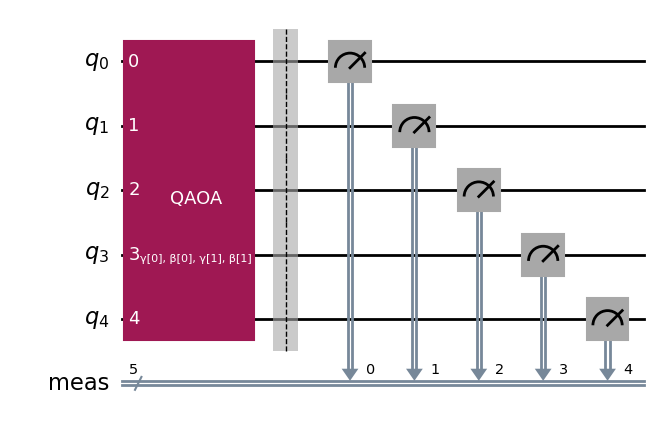

In [89]:
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()
 
circuit.draw("mpl")

In [48]:
decomposed = circuit.decompose().decompose().decompose()
from qiskit.qasm3 import dumps

decomposed_qasm_string = dumps(decomposed)

In [49]:
import qbraid 
provider = qbraid.QbraidProvider()
aws_device_id = "aws_sv1"
device = provider.get_device(aws_device_id)
device

<qbraid.runtime.native.device.QbraidDevice('aws_sv1')>

In [59]:
qiskit_sim = AerSimulator()

In [60]:
estimator = Estimator(qiskit_sim)

AerSimulator('aer_simulator')


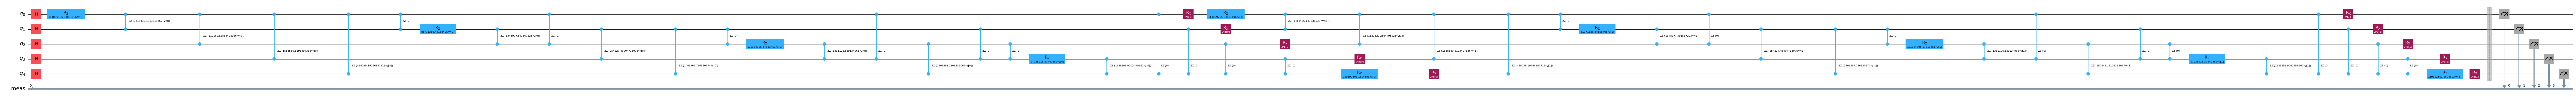

In [90]:
# service = QiskitRuntimeService()
backend = qiskit_sim
print(backend)
 
# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
 
candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [91]:
initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

In [92]:
def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
 
    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])
 
    results = job.result()[0]
    cost = results.data.evs
 
    objective_func_vals.append(cost)
 
    return cost

In [166]:
objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 100000
 
    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"
 
    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -31848361.276171833
       x: [ 1.465e+00  2.572e+00  3.569e+00  4.378e+00]
    nfev: 16
   maxcv: 0.0


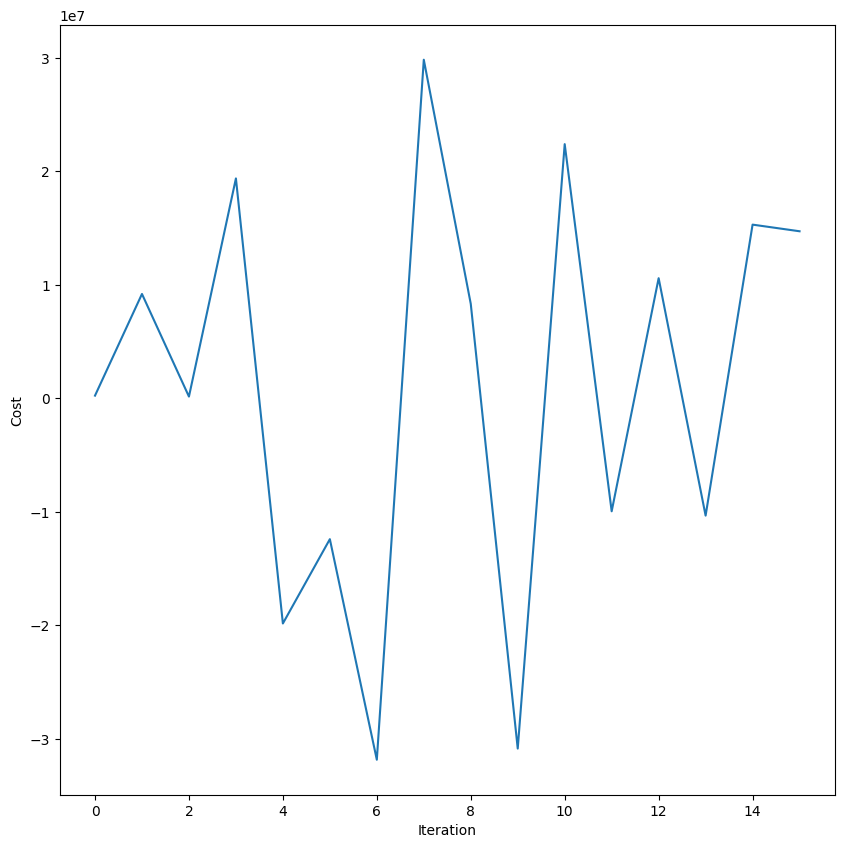

In [167]:
plt.figure(figsize=(10, 10))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.show()

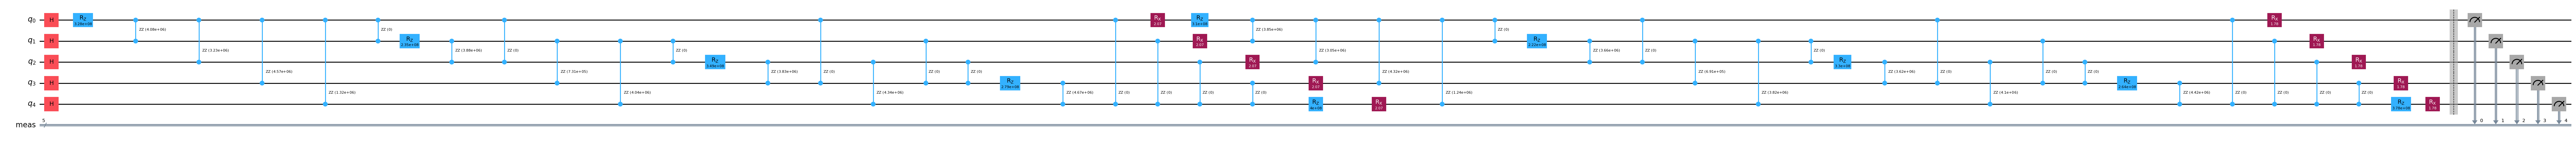

In [95]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)

optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [113]:
job = qiskit_sim.run(optimized_circuit, shots=int(1e4))
job.result()

Result(backend_name='aer_simulator', backend_version='0.17.1', job_id='eacaf9c5-2455-444d-bc0c-0a7984a93c09', success=True, results=[ExperimentResult(shots=10000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x3': 6, '0x18': 43, '0x2': 78, '0x1e': 142, '0x9': 54, '0x0': 453, '0x4': 92, '0x1b': 295, '0x1a': 412, '0x1': 122, '0x15': 261, '0x5': 404, '0x12': 796, '0xb': 196, '0x1c': 447, '0xa': 477, '0xd': 294, '0x17': 128, '0x13': 100, '0xe': 987, '0x7': 986, '0x14': 544, '0x8': 114, '0x11': 481, '0x19': 89, '0x10': 117, '0x6': 93, '0x1d': 126, '0x16': 290, '0x1f': 1169, '0xf': 204}), header={'creg_sizes': [['meas', 5]], 'global_phase': 0.0, 'memory_slots': 5, 'n_qubits': 5, 'name': 'QAOA-702', 'qreg_sizes': [['q', 5]], 'metadata': {}}, status=DONE, seed_simulator=2099532849, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 8, 'parallel_shots': 1, 'sample_measure_time': 0.002874084, 'noise': 'ideal', 'batched_shots_optimization':

In [149]:
{bin(int(k, 16)): v for k, v in job.result().results[0].data.counts.items()}

{'0b11': 6,
 '0b11000': 43,
 '0b10': 78,
 '0b11110': 142,
 '0b1001': 54,
 '0b0': 453,
 '0b100': 92,
 '0b11011': 295,
 '0b11010': 412,
 '0b1': 122,
 '0b10101': 261,
 '0b101': 404,
 '0b10010': 796,
 '0b1011': 196,
 '0b11100': 447,
 '0b1010': 477,
 '0b1101': 294,
 '0b10111': 128,
 '0b10011': 100,
 '0b1110': 987,
 '0b111': 986,
 '0b10100': 544,
 '0b1000': 114,
 '0b10001': 481,
 '0b11001': 89,
 '0b10000': 117,
 '0b110': 93,
 '0b11101': 126,
 '0b10110': 290,
 '0b11111': 1169,
 '0b1111': 204}

In [147]:
int("0x3", 16)

3

In [ ]:
# #If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
# sampler = Sampler(mode=backend)
# sampler.options.default_shots = 10000

# # Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

job = qiskit_sim.run(optimized_circuit, shots=int(1e4))
# counts_int = job.result().data.get_int_counts()
# counts_bin = job.result()
# print(counts_bin.data)
# shots = sum(counts_int.values())
# final_distribution_int = {key: val / shots for key, val in counts_int.items()}
# final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
# print(final_distribution_int)

In [50]:
# qasm_3 = transpile(circuit.decompose(), 'qasm3')
# print(qasm_3)

braket_job = device.run(decomposed_qasm_string, shots=10)
braket_job.status()

ERROR:pyqasm: Error at line 13, column 21 in QASM file

 >>>>>> _γ_0_

ERROR:pyqasm: Error at line 13, column 0 in QASM file

 >>>>>> p(114099755.84081106 * _γ_0_) q[0];




ProgramConversionError: Failed to convert 'qasm3' to 'braket' due to the following error(s):

Conversion qasm3 -> braket failed due to exception raised while converting from 'qasm3'.
ValidationError: Invalid parameter '114099755.84081106 * _γ_0_' for gate 'p'
